In [1]:
import sys
sys.path.append('..')
from utils import load_iterable_dataset
from transformer_lens import HookedTransformer
import torch as t
from tqdm import tqdm

In [25]:
DTYPE = t.bfloat16
MODEL_NAME = "roneneldan/TinyStories-33M"
ctx_len = 256
n_batches = 10
batch_size = 128

In [26]:
data = load_iterable_dataset('roneneldan/TinyStories')

In [27]:
model = HookedTransformer.from_pretrained(MODEL_NAME, device='cuda', dtype=DTYPE)

Loaded pretrained model roneneldan/TinyStories-33M into HookedTransformer


In [28]:
losses = []
for i in tqdm(range(n_batches)):
    batch = []
    for _ in range(batch_size):
        found=False
        while not found:
            text = next(data)
            tokens = model.to_tokens([text], prepend_bos=True)
            if tokens.shape[1] >= ctx_len:
                batch.append(text)
                found=True

    tokens = model.to_tokens(batch, prepend_bos=False)[:, :ctx_len]
  
    with t.no_grad():
        loss = model(
            tokens, 
            return_type="loss",
            loss_per_token=True
        )
    losses.append(loss)

100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


In [29]:
all_losses = t.cat(losses)
loss_per_token_nobos = all_losses.mean(dim=0)


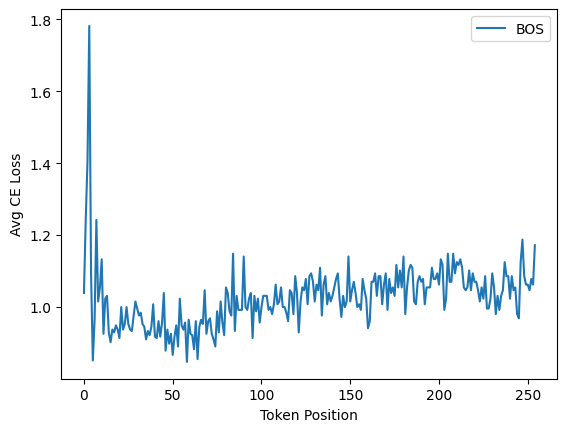

In [30]:
import matplotlib.pyplot as plt
# plt.plot(loss_per_token_bos.float().cpu().numpy())
plt.plot(loss_per_token_nobos.float().cpu().numpy())
# axis labels
plt.xlabel('Token Position')
plt.ylabel('Avg CE Loss')
# legend
plt.legend(['BOS', 'no BOS'])

In [31]:
loss_per_token_nobos[:128].mean()

tensor(0.9922, device='cuda:0', dtype=torch.bfloat16)

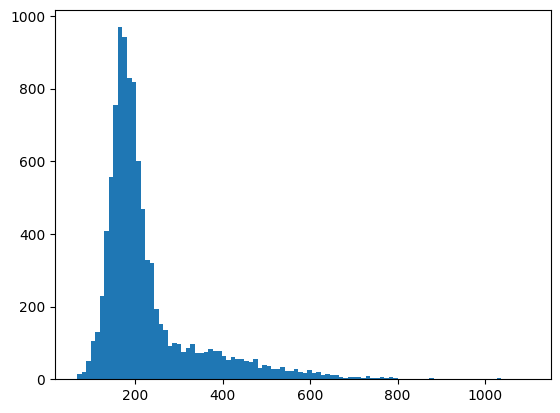

In [35]:
lengths = []
for _ in range(10000):
    text = next(data)
    tokens = model.to_tokens([text], prepend_bos=True)
    lengths.append(tokens.shape[1])
plt.hist(lengths, bins=100)
plt.show()